In [1]:
from sena.data.norec.dataloader import load_full_dataset
import sena.utils.preprocessing as preprocessing
import pandas as pd

In [2]:
data = load_full_dataset()

train = data["train"].copy()
val = data["dev"].copy()
test = data["test"].copy()

train["label"] = train["label"].replace({0: "negative", 1: "neutral", 2: "positive"})
val["label"] = val["label"].replace({0: "negative", 1: "neutral", 2: "positive"})
test["label"] = test["label"].replace({0: "negative", 1: "neutral", 2: "positive"})

train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

train = preprocessing.clean_text(train, "text")
val = preprocessing.clean_text(val, "text")
test = preprocessing.clean_text(test, "text")

combined_data = pd.concat([train.copy(), val.copy(), test.copy()]).reset_index(drop=True)

In [3]:
combined_data

,text,label
0,uvanlig tamt hiatt amerikaneren gjentar album ...,neutral
1,black mass johnny depp bedre filmen johnny dep...,neutral
2,færreste henger gitarkjøret mikser country fol...,positive
3,langdryg krigsestetikk kineserne storslåtte sl...,neutral
4,suggererande psykologisk thrillar rachel hovud...,positive
...,...,...
43609,kypros minus one alter ego hilser ringreven th...,neutral
43610,tenk banalt kvinnefribryting åttitallet temati...,positive
43611,store ponnyporno nrks nye gullrekkereality byr...,neutral
43612,anmeldelsekarpe diem slottsfjell slottsfjell b...,positive


In [4]:
train

,text,label
0,uvanlig tamt hiatt amerikaneren gjentar album ...,neutral
1,black mass johnny depp bedre filmen johnny dep...,neutral
2,færreste henger gitarkjøret mikser country fol...,positive
3,langdryg krigsestetikk kineserne storslåtte sl...,neutral
4,suggererande psykologisk thrillar rachel hovud...,positive
...,...,...
34898,minor majoritysjefen skrur tempoet solodebut r...,neutral
34899,falkevikny jazztrio popteft bringer velfungere...,positive
34900,mowgli dystrere versjon jungelboken år disneys...,neutral
34901,kreking brosnan hayek ganske elegant liten dia...,neutral


In [5]:
val

,text,label
0,beethovens niende lag ideologi viser slitestyr...,neutral
1,oboy kommer mislike filmen norsk svartmetall i...,positive
2,sovende pengesluk dagen mobilspillene utkonkur...,neutral
3,resogun best playstation akkurat ironien ta fø...,positive
4,fleksibel lekkerbisken asus kvalitetsfølelse d...,neutral
...,...,...
4355,american honey feberaktig roadmovie utrolig ne...,positive
4356,gjenbruker egen tekst trygve liebok svært bete...,negative
4357,lett la bevege youtubefenomenet future islands...,neutral
4358,lyser mørke cubicals frontfigur dan wilson lig...,positive


In [6]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words) / 20
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 26000


<AxesSubplot:>

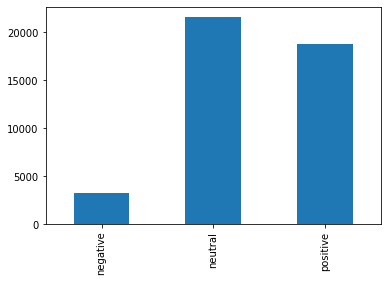

In [7]:
combined_data["label"].value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

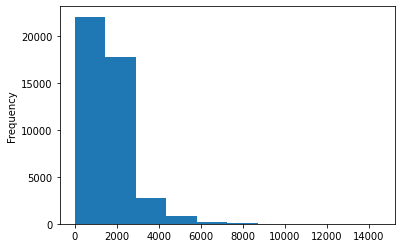

In [8]:
combined_data["text"].str.len().plot.hist()

In [9]:
average_text_length = combined_data["text"].str.len().mean()
max_text_length = combined_data["text"].str.len().max()
print("Average text length:", int(average_text_length))
print("Max text length:", int(max_text_length))

Average text length: 1623
Max text length: 14505


In [10]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import numpy as np

X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

maxlen = (int(np.ceil(np.mean([len(text.split()) for text in combined_data.text]))))

tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_data["text"].tolist())

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=maxlen, padding="post", truncating="post")

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val, maxlen=maxlen, padding="post", truncating="post")

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=maxlen, padding="post", truncating="post")

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(combined_data["label"].tolist())

y_train = np.array(label_tokenizer.texts_to_sequences(y_train))
y_val = np.array(label_tokenizer.texts_to_sequences(y_val))
y_test = np.array(label_tokenizer.texts_to_sequences(y_test))

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34903, 204)
y_train shape: (34903, 1)

X_val shape: (4360, 204)
y_val shape: (4360, 1)

X_test shape: (4351, 204)
y_test shape: (4351, 1)


In [11]:
from collections import Counter

combined_text = tokenizer.texts_to_sequences(combined_data["text"])

word_counter = Counter()
for review in combined_text:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [12]:
word_counter.most_common(10)

[('<OOV>', 1456494),
 ('litt', 35145),
 ('får', 34541),
 ('gjør', 27955),
 ('helt', 27035),
 ('godt', 26690),
 ('filmen', 26493),
 ('år', 25426),
 ('alt', 23592),
 ('nok', 23554)]

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional

model = Sequential()
model.add(Embedding(num_words, 64))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

In [14]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1664000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 1,730,564
Trainable params: 1,730,564
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 64

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stop])

Epoch 1/20
546/546 [==============================] - 1098s 2s/step - loss: 0.8487 - accuracy: 0.5816 - val_loss: 0.7605 - val_accuracy: 0.6388
Epoch 2/20
546/546 [==============================] - 744s 1s/step - loss: 0.6256 - accuracy: 0.7239 - val_loss: 0.6882 - val_accuracy: 0.6867
Epoch 3/20
546/546 [==============================] - 572s 1s/step - loss: 0.4421 - accuracy: 0.8202 - val_loss: 0.7552 - val_accuracy: 0.6718
Epoch 4/20
546/546 [==============================] - 583s 1s/step - loss: 0.2853 - accuracy: 0.8932 - val_loss: 0.9543 - val_accuracy: 0.6589
Epoch 5/20
546/546 [==============================] - 566s 1s/step - loss: 0.1628 - accuracy: 0.9435 - val_loss: 1.2049 - val_accuracy: 0.6472


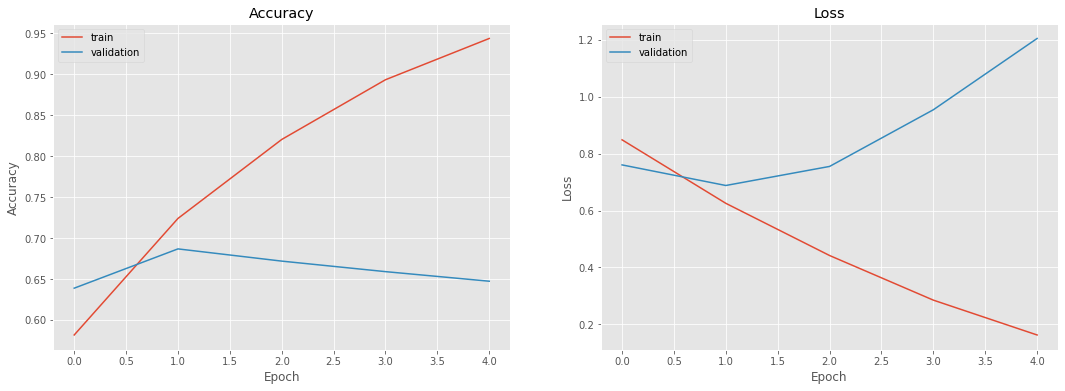

In [16]:
from sena.utils.visualization import plot_history

plot_history(history)

In [17]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

136/136 [==============================] - 5s 39ms/step - loss: 1.1849 - accuracy: 0.6553
Validation loss: 1.1848549842834473
Validation accuracy: 0.655251681804657


In [18]:
from datetime import datetime

if val_acc > 0.8:
    model.save(f"models/SA-LSTM-MULTICLASS-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")